In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
# from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, Normalize, get_distance_matrix, cdist
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES


# Zero-shot cross-modal decoding

loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects


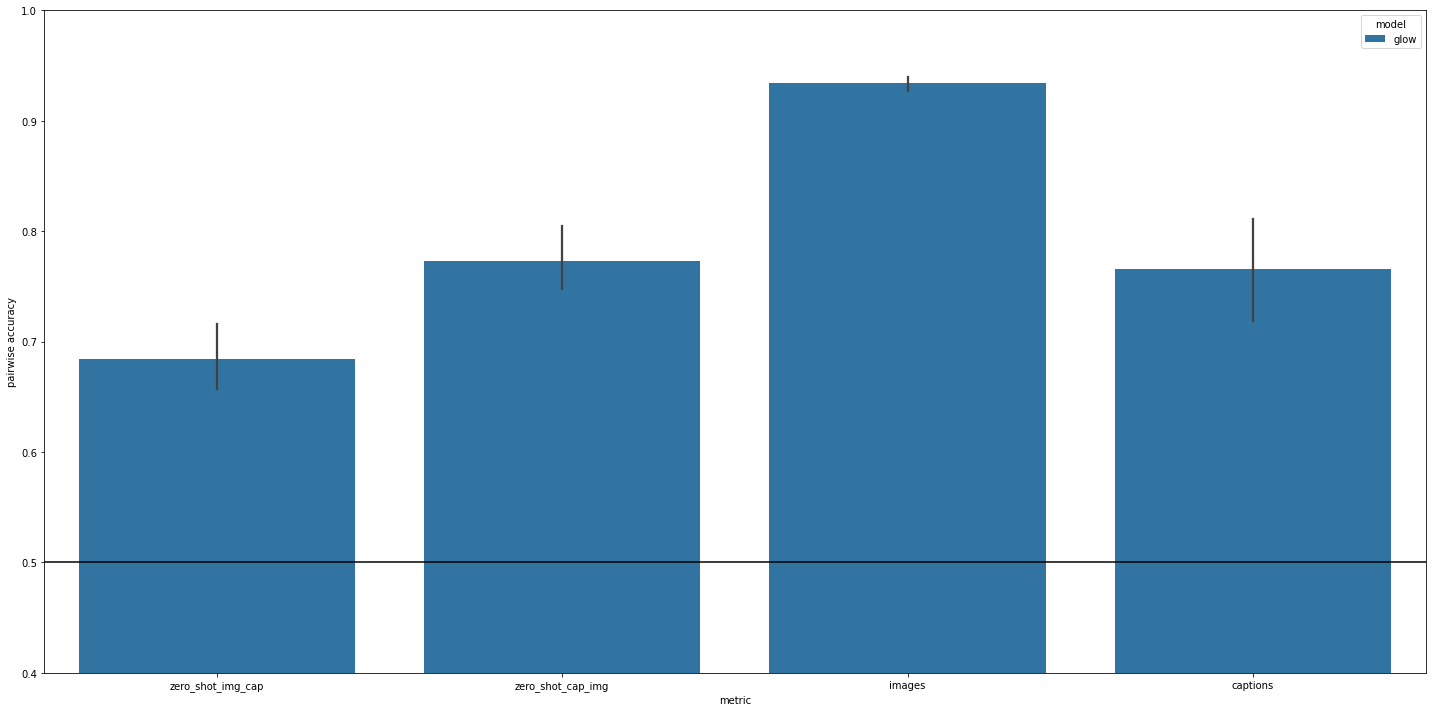

In [20]:
models = ["glow", "glow-contrastive"]
results_table = calc_zero_shot_scores(models)

plt.figure(figsize=(20, 10))
sns.barplot(data=results_table, x="metric", y="value", hue="model")
plt.ylim((0.4, 1))
plt.axhline(y=0.5, color="black")
plt.ylabel("pairwise accuracy")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "glow_zero_shot_cross_modal_decoding.png"), dpi=300, facecolor='white', transparent=False)

loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 0 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded r

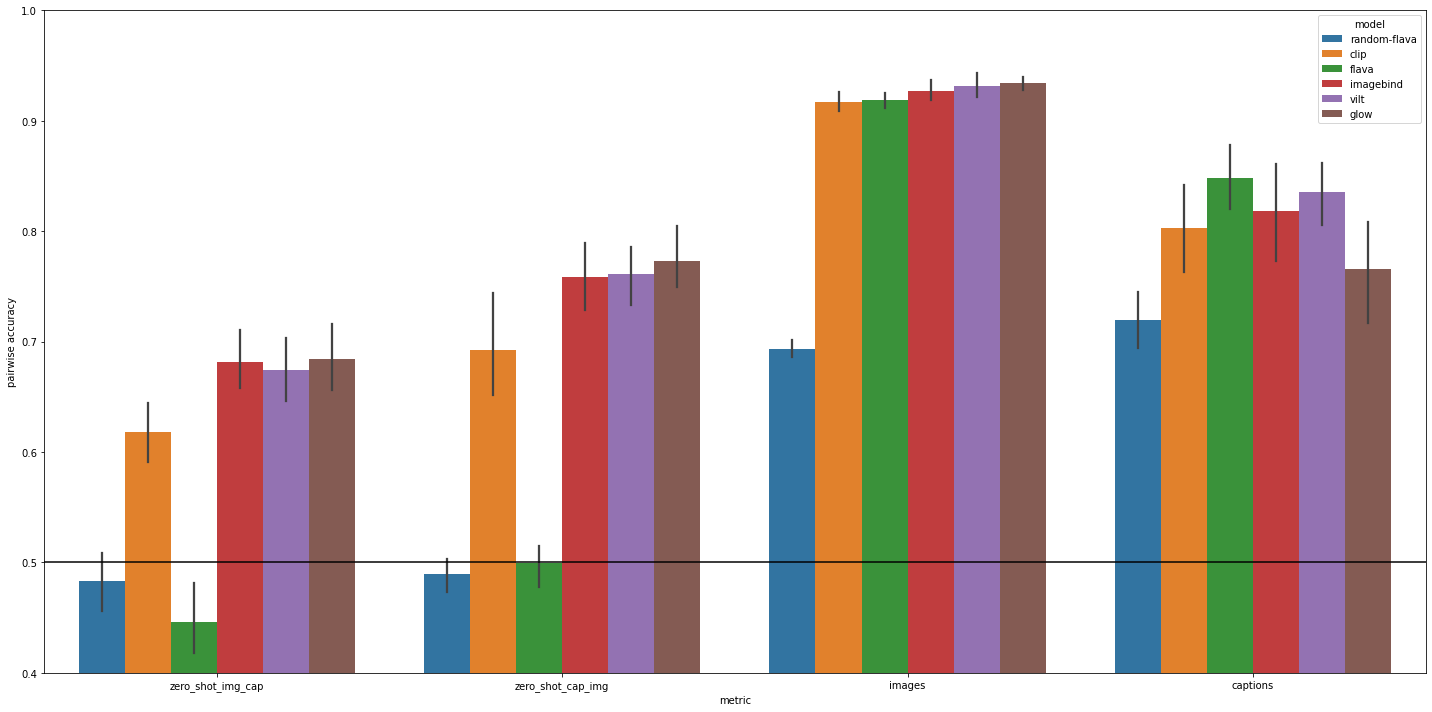

In [21]:
models = ["random-flava", "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt", "glow"]
results_table = calc_zero_shot_scores(models)

plt.figure(figsize=(20, 10))
sns.barplot(data=results_table, x="metric", y="value", hue="model")
plt.ylim((0.4, 1))
plt.axhline(y=0.5, color="black")
plt.ylabel("pairwise accuracy")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "zero_shot_cross_modal_decoding.png"), dpi=300, facecolor='white', transparent=False)

In [189]:
IMAGE = "image"
CAPTION = "caption"


def pairwise_accuracy(latents, predictions, stimulus_ids, stim_types, metric="cosine", normalize=True):
    results = dict()

    for modality in [CAPTION, IMAGE]:
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if normalize:
            pred_mod_normalize = Normalize(preds_mod.mean(axis=0), preds_mod.std(axis=0))
            preds_mod = pred_mod_normalize(preds_mod)
    
        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat
        results[f"pairwise_acc_{modality}s"] = comp_mat.mean()

    if normalize:
        pred_normalize = Normalize(predictions.mean(axis=0), predictions.std(axis=0))
        predictions = pred_normalize(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]

        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min

        scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.extend(scores)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = scores.mean()
        
    results[f"pairwise_acc_modality_agnostic"] = np.mean(mod_agnostic_accs)
    print(results)

    return results


In [190]:
def get_scores(model, train_features, test_features, train_mode, test_mode):
    acc_scores = []
    results_all_subjects_train = load_results_files(model, train_features, train_mode)
    results_all_subjects_test = load_results_files(model, test_features, test_mode)
    assert len(results_all_subjects_train) == len(results_all_subjects_test)
    print(f"loaded results from {len(results_all_subjects_train)} subjects")
    for results_train, results_test in zip(results_all_subjects_train, results_all_subjects_test):
        preds = results_train[PREDS]
        
        targets = results_test[TARGETS]
        # acc_caps = pairwise_accuracy(targets[results_train[STIM_TYPES] == CAPTION], preds[results_train[STIM_TYPES] == CAPTION], results_train[STIM_IDS][results_train[STIM_TYPES] == CAPTION], results_train[STIM_TYPES][results_train[STIM_TYPES] == CAPTION])

        acc = pairwise_accuracy(targets, preds, results_train[STIM_IDS], results_train[STIM_TYPES])

        acc_scores.append(acc)
        return #TODO

    return acc_scores

def calc_zero_shot_scores(models):
    results = []
    for model in models: 
        scores_img_cap = get_scores(model, "matched", "matched", "train", "train")
    
models = ["glow-contrastive"]
results_table = calc_zero_shot_scores(models)


loaded results from 6 subjects
{'pairwise_acc_captions': 0.8042857142857143, 'pairwise_acc_images': 0.9132653061224489, 'pairwise_acc_mod_agnostic_captions': 0.7761224489795918, 'pairwise_acc_mod_agnostic_images': 0.9210204081632651, 'pairwise_acc_modality_agnostic': 0.8485714285714285}


In [ ]:
#{'pairwise_acc_captions': 0.8042857142857143, 'pairwise_acc_mod_agnostic_captions': 0.8120408163265306, 'pairwise_acc_images': 0.9132653061224489,
# 'pairwise_acc_mod_agnostic_images': 0.9179591836734693, 'pairwise_acc_modality_agnostic': 0.8650000000000001}

#
{'pairwise_acc_captions': 0.7777551020408163, 'pairwise_acc_mod_agnostic_captions': 0.7761224489795918, 'pairwise_acc_images': 0.9202040816326531, 
 'pairwise_acc_mod_agnostic_images': 0.9210204081632651, 'pairwise_acc_modality_agnostic': 0.8485714285714285}
